<h1>Index<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Instrucciones-del-proyecto." data-toc-modified-id="Instrucciones-del-proyecto.-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Instrucciones del proyecto.</a></span></li><li><span><a href="#Descripción-de-los-datos" data-toc-modified-id="Descripción-de-los-datos-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Descripción de los datos</a></span><ul class="toc-item"><li><span><a href="#Datos-y-librerias" data-toc-modified-id="Datos-y-librerias-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Datos y librerias</a></span></li><li><span><a href="#Conociendo-los-datos" data-toc-modified-id="Conociendo-los-datos-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Conociendo los datos</a></span></li></ul></li><li><span><a href="#Preparación" data-toc-modified-id="Preparación-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Preparación</a></span><ul class="toc-item"><li><span><a href="#Features-y-targets" data-toc-modified-id="Features-y-targets-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Features y targets</a></span></li></ul></li><li><span><a href="#Análisis" data-toc-modified-id="Análisis-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Análisis</a></span></li><li><span><a href="#Formación" data-toc-modified-id="Formación-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Formación</a></span><ul class="toc-item"><li><span><a href="#Prueba-de-cordura-con-regresión-lineal" data-toc-modified-id="Prueba-de-cordura-con-regresión-lineal-5.1"><span class="toc-item-num">5.1&nbsp;&nbsp;</span>Prueba de cordura con regresión lineal</a></span></li><li><span><a href="#Bosque-aleatorio-con-ajuste-de-hiperparámetros" data-toc-modified-id="Bosque-aleatorio-con-ajuste-de-hiperparámetros-5.2"><span class="toc-item-num">5.2&nbsp;&nbsp;</span>Bosque aleatorio con ajuste de hiperparámetros</a></span></li><li><span><a href="#CatBoost" data-toc-modified-id="CatBoost-5.3"><span class="toc-item-num">5.3&nbsp;&nbsp;</span>CatBoost</a></span></li><li><span><a href="#LightGBM" data-toc-modified-id="LightGBM-5.4"><span class="toc-item-num">5.4&nbsp;&nbsp;</span>LightGBM</a></span></li></ul></li><li><span><a href="#Prueba" data-toc-modified-id="Prueba-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Prueba</a></span></li></ul></div>

# Descripción del proyecto

La compañía Sweet Lift Taxi ha recopilado datos históricos sobre pedidos de taxis en los aeropuertos. Para atraer a más conductores durante las horas pico, necesitamos predecir la cantidad de pedidos de taxis para la próxima hora. Construye un modelo para dicha predicción.

La métrica RECM en el conjunto de prueba no debe ser superior a 48.

## Instrucciones del proyecto.

1. Descarga los datos y haz el remuestreo por una hora.
2. Analiza los datos
3. Entrena diferentes modelos con diferentes hiperparámetros. La muestra de prueba debe ser el 10% del conjunto de datos inicial.
4. Prueba los datos usando la muestra de prueba y proporciona una conclusión.

## Descripción de los datos 

Los datos se almacenan en el archivo `taxi.csv`. 	
El número de pedidos está en la columna `num_orders`.

### Datos y librerias

In [127]:
# Librerias
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math

from sklearn.model_selection import train_test_split

from catboost import CatBoostRegressor
import lightgbm as lgb
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor

from sklearn.metrics import mean_squared_error
from statsmodels.tsa.seasonal import seasonal_decompose

from numpy.random import RandomState
from sklearn.model_selection import GridSearchCV


In [128]:
# Datos

try:
    df = pd.read_csv('C:/Users/tomas/Downloads/taxi.csv', index_col=[0], parse_dates=[0])
except:
    df = pd.read_csv('/datasets/taxi.csv', index_col=[0], parse_dates=[0])
    
            # Aprovechamos a utilizar como índice las fechas

### Conociendo los datos

In [129]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


Luego de utilizar la columna `datetime` como indice nos queda solo una columna de datos numéricos. Además, no tenemos datos faltantes. Veamos algunos datos de esta columna.

In [130]:
df.head()

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


In [131]:
df.describe()

,num_orders
count,26496.000000
mean,14.070463
std,9.211330
min,0.000000
25%,8.000000
50%,13.000000
75%,19.000000
max,119.000000


La media y el promedio se encuentran a poco menos de un punto de diferencia. Podría parecer que tenemos una muestra cercana al equilibrio, pero tenemos valores extremadamente altos, aunque probablemente no sean muchos. Utilicemos `boxplot` para ver como se distribuyen los datos.

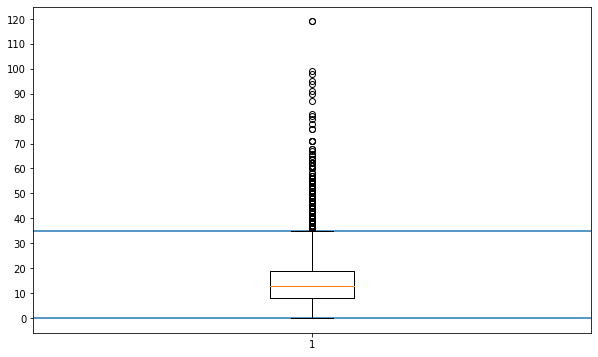

In [132]:
plt.figure(figsize=(10,6))
plt.boxplot(df)
plt.hlines(35, xmin=0.5, xmax=1.5)
plt.hlines(0, xmin=0.5, xmax=1.5)
plt.yticks(np.arange(0, 121, 10))
plt.show()

Como predijimos, tenemos valores altos que se encuentran fuera de la norma. No eliminaremos estos datos, en cambio estos datos nos dicen que el rango normal de viajes se encuentra entre 0 y 35 viajes cada 10 minutos. Veamos algunas gráficas más para tener una mejor visión de los datos.

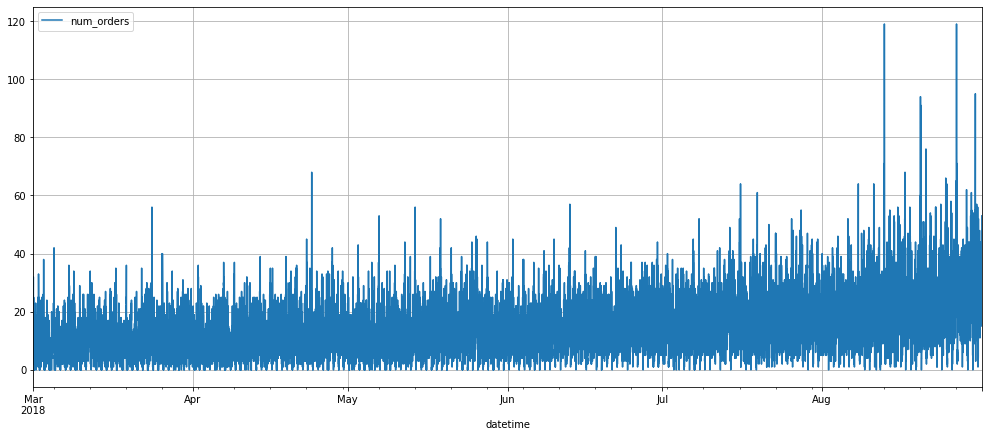

In [133]:
df.plot(figsize=(17,7), grid=True)
plt.show()

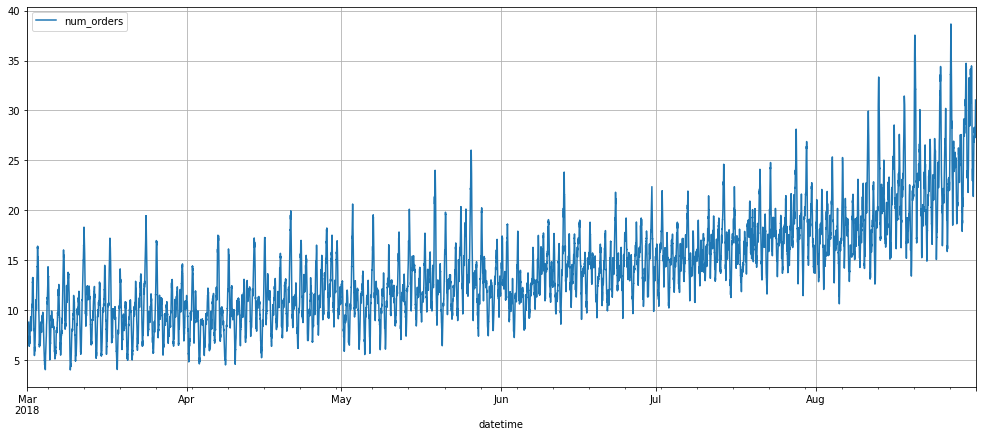

In [134]:
df.rolling(50).mean().plot(figsize=(17,7), grid=True)
plt.show()

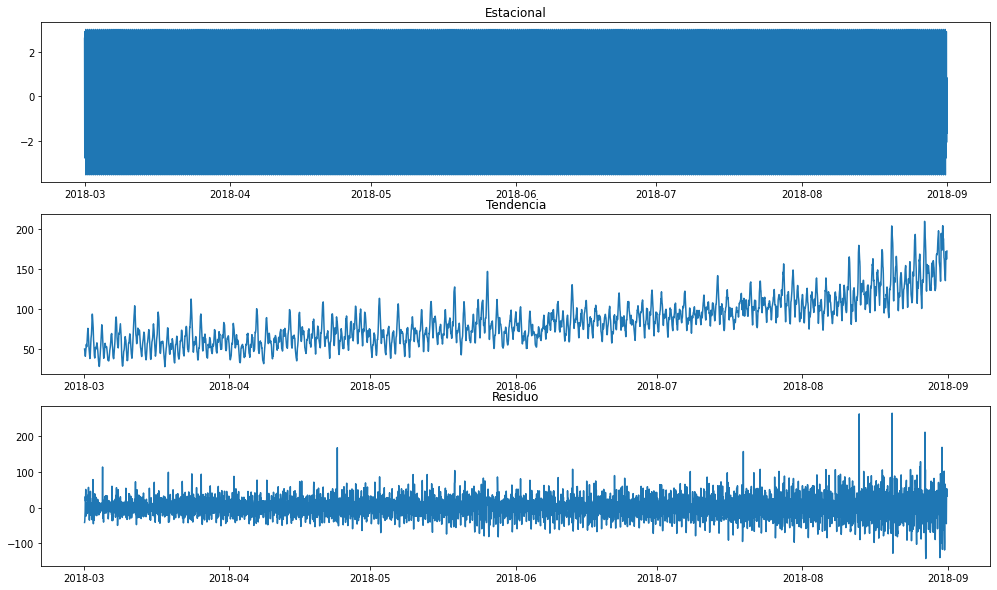

In [135]:
seasonal = seasonal_decompose(df.resample('1H').sum(), model='additive', period=10)

fig, ax = plt.subplots(3, figsize=(17,10))
ax[0].plot(seasonal.seasonal)
ax[0].set_title('Estacional')
ax[1].plot(seasonal.trend)
ax[1].set_title('Tendencia')
ax[2].plot(seasonal.resid)
ax[2].set_title('Residuo')
plt.show()

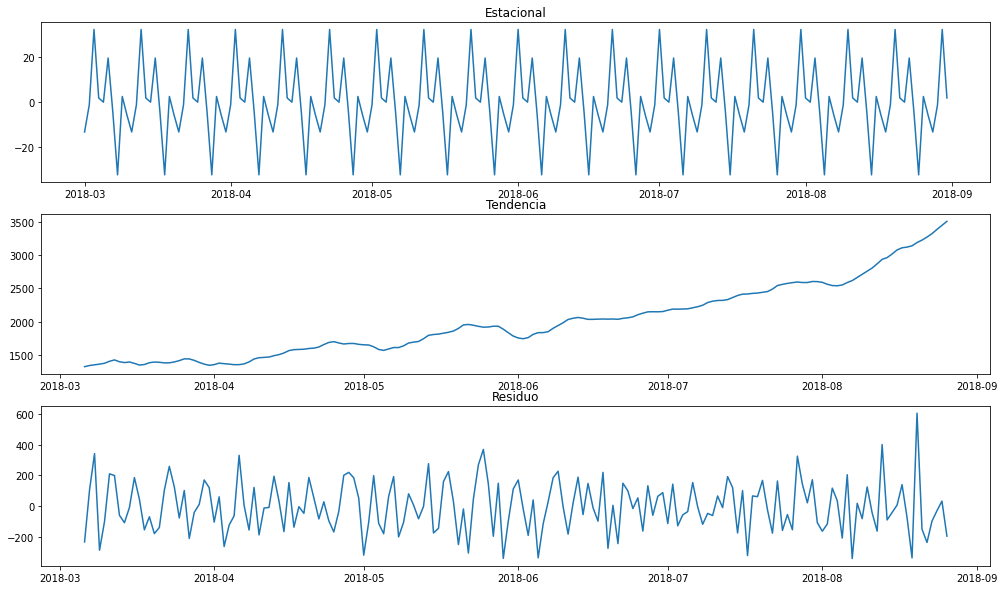

In [136]:
seasonal = seasonal_decompose(df.resample('1D').sum(), model='additive', period=10)

fig, ax = plt.subplots(3, figsize=(17,10))
ax[0].plot(seasonal.seasonal)
ax[0].set_title('Estacional')
ax[1].plot(seasonal.trend)
ax[1].set_title('Tendencia')
ax[2].plot(seasonal.resid)
ax[2].set_title('Residuo')
plt.show()

Podemos ver que existe un componente estacional cuando nos fijamos por dia. Probablemente durante una semana tendremos días con alta y con baja cantidad de viajes.

## Preparación

Cuando tenemos tendencia, podemos diferenciar los datos hasta que tengamos estacionariedad. Si tenemos problemas de volatilidad, es decir, la varianza no es la misma en toda la serie, podemos utilizar modelos ARCH o GARCH.

Ahora que conocemos los datos con los que trabajaremos, pasemos ahora a crear las features para nuestro modelo, pero primero cambiaremos los rangos de tiempo medidos. Los datos se encuentran medidos en rangos de 10 minutos, pero el proyecto nos pide predecir los viajes en la próxima hora. Cambiaremos los rangos a una hora para poder realizar estas predicciones.

In [137]:
df_h = df.resample('1H').sum()

df_h.head()

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43


In [151]:
def make_features(data, max_lag, rolling_mean_size):
    data['hour'] = data.index.hour
    data['month'] = data.index.month
    data['day'] = data.index.day
    data['dayofweek'] = data.index.dayofweek

    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)

    data['rolling_mean'] = data['num_orders'].shift().rolling(rolling_mean_size).mean()
    return data

In [152]:
df_ft = make_features(df_h, 4, 6)

df_ft.head(10)

,num_orders,month,day,lag_1,lag_2,lag_3,lag_4,rolling_mean,hour,dayofweek
datetime,,,,,,,,,,
2018-03-01 06:00:00,12,3,1,NaN,NaN,NaN,NaN,NaN,6,3
2018-03-01 07:00:00,15,3,1,12.0,NaN,NaN,NaN,NaN,7,3
2018-03-01 08:00:00,34,3,1,15.0,12.0,NaN,NaN,NaN,8,3
2018-03-01 09:00:00,69,3,1,34.0,15.0,12.0,NaN,NaN,9,3
2018-03-01 10:00:00,64,3,1,69.0,34.0,15.0,12.0,NaN,10,3
2018-03-01 11:00:00,96,3,1,64.0,69.0,34.0,15.0,NaN,11,3
2018-03-01 12:00:00,30,3,1,96.0,64.0,69.0,34.0,48.333333,12,3
2018-03-01 13:00:00,32,3,1,30.0,96.0,64.0,69.0,51.333333,13,3
2018-03-01 14:00:00,48,3,1,32.0,30.0,96.0,64.0,54.166667,14,3


Antes de continuar, eliminemos los valores vacíos que quedaron en nuestros datos.

In [156]:
df_ft.dropna(inplace=True)

df_ft.head()

,num_orders,month,day,lag_1,lag_2,lag_3,lag_4,rolling_mean,hour,dayofweek
datetime,,,,,,,,,,
2018-03-01 12:00:00,30,3,1,96.0,64.0,69.0,34.0,48.333333,12,3
2018-03-01 13:00:00,32,3,1,30.0,96.0,64.0,69.0,51.333333,13,3
2018-03-01 14:00:00,48,3,1,32.0,30.0,96.0,64.0,54.166667,14,3
2018-03-01 15:00:00,66,3,1,48.0,32.0,30.0,96.0,56.500000,15,3
2018-03-01 16:00:00,43,3,1,66.0,48.0,32.0,30.0,56.000000,16,3


### Features y targets

In [153]:
rs = RandomState(54321) # Fijemos una semilla para estabilidad

Ahora que tenemos nuestras características y objetivos listos, dividamos los datos para alimentar a nuestros modelos. Recordemos que se nos pide que dejemos un 10% de los datos para el testeo final.

In [157]:
# Separamos los datos de testeo del resto de los datos
rest, test = train_test_split(df_ft, shuffle=False, test_size=0.1)

# Separamos los datos para entrenamiento y validación
train, valid = train_test_split(rest, test_size=0.25, random_state=rs)

# Creamos features y targets para entrenaminto
features_train = train.drop('num_orders', axis=1)
targets_train = train['num_orders']

# Creamos features y targets para testeo
features_test = test.drop('num_orders', axis=1)
targets_test = test['num_orders']

# Creamos features y targets para validación
features_valid = valid.drop('num_orders', axis=1)
targets_valid = valid['num_orders']

# Creamos features y targets para el entrenamiento de la validación
features_rest = rest.drop('num_orders', axis=1)
targets_rest = rest['num_orders']

# Comprobemos el tamaño de los sets
print('Entrenamiento:')
print(features_train.shape)
print(targets_train.shape)
print()
print('Validación:')
print(features_valid.shape)
print(targets_valid.shape)
print()
print('Testeo')
print(features_test.shape)
print(targets_test.shape)

Entrenamiento:
(2972, 9)
(2972,)

Validación:
(991, 9)
(991,)

Testeo
(441, 9)
(441,)


## Análisis

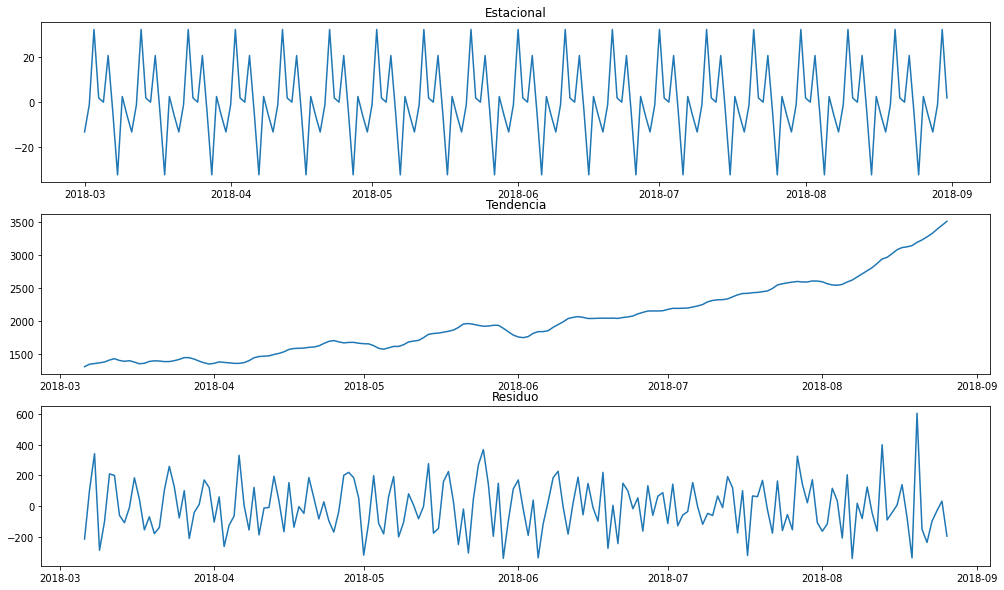

In [142]:
seasonal = seasonal_decompose(df_ft['num_orders'].resample('1D').sum(), model='additive', period=10)

fig, ax = plt.subplots(3, figsize=(17,10))
ax[0].plot(seasonal.seasonal)
ax[0].set_title('Estacional')
ax[1].plot(seasonal.trend)
ax[1].set_title('Tendencia')
ax[2].plot(seasonal.resid)
ax[2].set_title('Residuo')
plt.show()

Al parecer la componente estacional ha cambiado con los cambios que hemos hecho. Esta tiene ahora valores un poco mayores a los originales y su forma ha cambiado. Aún así no es suficiente para cambiar la tendencia de los datos. Con solo fijarnos en las unidades podemos ver que la parte estacional de los datos no afectan realmente a la cantidad de viajes totales. Por otro lado el residuo llega a acercarse al 10% de la tendencia, este valor es considerablemente alto y alterará a nuestros modelos. Esperemos que con una afinación de los hiperparámetros podamos solucionar este problema.

## Formación

En esta sección enfrentaremos los diferentes modelos entre ellos e intentaremos obtener el menor RECM posible. Además tenemos la condición de que este valor no puede superar el valor de 48.

### Prueba de cordura con regresión lineal

Comencemos con una regresión lineal. Este modelo probablemente nos dé los peores resultados, pero por su rapidez es buena para establecer un punto de partida para los siguientes modelos.

In [158]:
reg = LinearRegression()
reg.fit(features_train, targets_train)
reg_pred = reg.predict(features_valid)
print('RECM:')
print(mean_squared_error(targets_valid, reg_pred)**0.5)

RECM:
31.03103149665031


¡Ya hemos superado la condición para los modelos! Tal vez este modelo si sea el indicado para este problema. Veamos los siguientes modelos y luego testearemos al mejor.

### Bosque aleatorio con ajuste de hiperparámetros

In [160]:
score = max(df['num_orders'])
n=1
for roots in range(3,8):
    for leafs in range(3,8):
        forest = RandomForestRegressor(random_state=rs, max_depth=roots, min_samples_leaf=leafs)
        forest.fit(features_train, targets_train)
        f_pred = forest.predict(features_valid)
        sco = mean_squared_error(targets_valid, f_pred)**0.5
        if sco<score:
            score = sco
            best_root = roots
            best_leaf = leafs
            best_pred = f_pred
            best_n = n
        n+=1

best_forest = RandomForestRegressor(random_state=rs, max_depth=best_root, min_samples_leaf=best_leaf)
print('Mejor ronda:', best_n)
print('Mejor RECM:', score)
print('Raices:', best_root)
print('Hojas:', best_leaf)

Mejor ronda: 21
Mejor RECM: 24.633493290668092
Raices: 7
Hojas: 3


Este modelo se toma mucho tiempo en ejecutar, pero podemos ver que el resultado a mejorado. Veamos si podemos seguir mejorando con el resto de los modelos.

### CatBoost

In [159]:
cat = CatBoostRegressor(iterations=200, silent=True)
cat.fit(features_train, targets_train, eval_set=(features_valid, targets_valid))
cat_pred = cat.predict(features_valid)
print('RECM:')
print(mean_squared_error(targets_valid, cat_pred)**0.5)

RECM:
22.34148256218729


Un modelo muy rápido y con mejores resultados. Las mejoras son pequeñas, pero se van acumulando. Lo importantes es que hemos superado al modelo anterior. Continuemos con el último modelo antes de decidir al ganador.

### LightGBM

In [161]:
lgbm = lgb.LGBMRegressor(random_state=rs)
lgbm.fit(features_train, targets_train,eval_metric = 'RMSE', eval_set=(features_valid, targets_valid))
lgbm_pred = lgbm.predict(features_valid)
print('RECM:')
print(mean_squared_error(targets_valid, lgbm_pred)**0.5)

[1]	valid_0's rmse: 37.3079	valid_0's l2: 1391.88
[2]	valid_0's rmse: 35.3874	valid_0's l2: 1252.27
[3]	valid_0's rmse: 33.8062	valid_0's l2: 1142.86
[4]	valid_0's rmse: 32.3172	valid_0's l2: 1044.4
[5]	valid_0's rmse: 31.1572	valid_0's l2: 970.773
[6]	valid_0's rmse: 30.1597	valid_0's l2: 909.606
[7]	valid_0's rmse: 29.2156	valid_0's l2: 853.553
[8]	valid_0's rmse: 28.4193	valid_0's l2: 807.658
[9]	valid_0's rmse: 27.7649	valid_0's l2: 770.892
[10]	valid_0's rmse: 27.1661	valid_0's l2: 738
[11]	valid_0's rmse: 26.7214	valid_0's l2: 714.033
[12]	valid_0's rmse: 26.245	valid_0's l2: 688.798
[13]	valid_0's rmse: 25.8254	valid_0's l2: 666.951
[14]	valid_0's rmse: 25.5826	valid_0's l2: 654.472
[15]	valid_0's rmse: 25.3408	valid_0's l2: 642.157
[16]	valid_0's rmse: 25.177	valid_0's l2: 633.882
[17]	valid_0's rmse: 24.8367	valid_0's l2: 616.864
[18]	valid_0's rmse: 24.5666	valid_0's l2: 603.518
[19]	valid_0's rmse: 24.1966	valid_0's l2: 585.475
[20]	valid_0's rmse: 24.0728	valid_0's l2: 579.

Por esta vez, tendremos que descartar a este modelo, pues no ha logrado superar a `CatBoost`, aunque ha estado muy cerca. Pasemos al testeo del mejor modelo.

## Prueba

In [178]:
cat = CatBoostRegressor(iterations=200, silent=True)
cat.fit(features_rest, targets_rest, eval_set=(features_test, targets_test))
cat_pred = cat.predict(features_test)
print('RECM:')
print(mean_squared_error(targets_test, cat_pred)**0.5)

RECM:
44.6135551393614


Al parecer la mayor cantidad de información con la que entrenamos a nuestro último modelo no nos dió mejores resultados. El valor de RECM ha aumentado a casi 44.6, pero aún nos encontramos bajo el máximo estipulado. Podemos asegurar con certeza que el modelo `CatBoost` es el mejor para poder predecir la cantidad de viajes que habrán en la siguiente hora. De todas formas, agregaremos otra ejecución de `CatBoost` con cambios de hiperparámetros.

In [179]:
score = max(df['num_orders'])
for metric in ['MAE', 'MAPE', 'Poisson', 'RMSE']:
    for roots in range(3,8):
        for leafs in range(3,8):
            cat2 = CatBoostRegressor(iterations=200, silent=True, l2_leaf_reg=leafs, depth=roots, loss_function=metric)
            cat2.fit(features_rest, targets_rest, eval_set=(features_test, targets_test))
            cat_pred = cat2.predict(features_test)
            sco = mean_squared_error(targets_test, cat_pred)**0.5
            if sco<score:
                score = sco
                best_root = roots
                best_leaf = leafs
                best_metric = metric
                best_pred = sco

print('RECM:', best_pred)
print('Depth:', best_root)
print('Leafs:', best_leaf)
print('Metric:', best_metric)

RECM: 49.192805512880724
Depth: 7
Leafs: 3
Metric: RMSE


El valor de RECM ha aumentado por sobre la máxima. Al parecer los hiperparámetros automáticos son mejores para nuestro modelo. Nos quedamos con la versión estándar del modelo `CatBoost`.

In [ ]:
score = max(df['num_orders'])
n=1
for roots in range(3,8):
    for leafs in range(3,8):
        for metric in ['mse', 'mae', 'poisson']:
            forest = RandomForestRegressor(random_state=rs, max_depth=roots, min_samples_leaf=leafs, criterion=metric)
            forest.fit(features_rest, targets_rest)
            f_pred = forest.predict(features_test)
            sco = mean_squared_error(targets_test, f_pred)**0.5
            if sco<score:
                score = sco
                best_root = roots
                best_leaf = leafs
                best_pred = f_pred
                best_n = n
                best_metric = metric
            n+=1

best_forest = RandomForestRegressor(random_state=rs, max_depth=best_root, min_samples_leaf=best_leaf)
print('Mejor ronda:', best_n)
print('Mejor RECM:', score)
print('Raices:', best_root)
print('Hojas:', best_leaf)
print('Metrica:', best_metric)